In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
#loading the data
df = pd.read_excel("/Users/prathamesh/Downloads/daily-total-female-births-CA.xlsx")

In [3]:
#gathering info from dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    365 non-null    datetime64[ns]
 1   births  365 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.8 KB


In [4]:
print(df.describe())

                      date      births
count                  365  365.000000
mean   1959-07-02 00:00:00   41.980822
min    1959-01-01 00:00:00   23.000000
25%    1959-04-02 00:00:00   37.000000
50%    1959-07-02 00:00:00   42.000000
75%    1959-10-01 00:00:00   46.000000
max    1959-12-31 00:00:00   73.000000
std                    NaN    7.348257


In [5]:
#converting date to datetime and making it the index of our data
df.date = pd.to_datetime(df.date)
df.set_index('date',drop=True,inplace=True)


In [6]:
#checking for missing values
print(df.isnull().sum())

births    0
dtype: int64


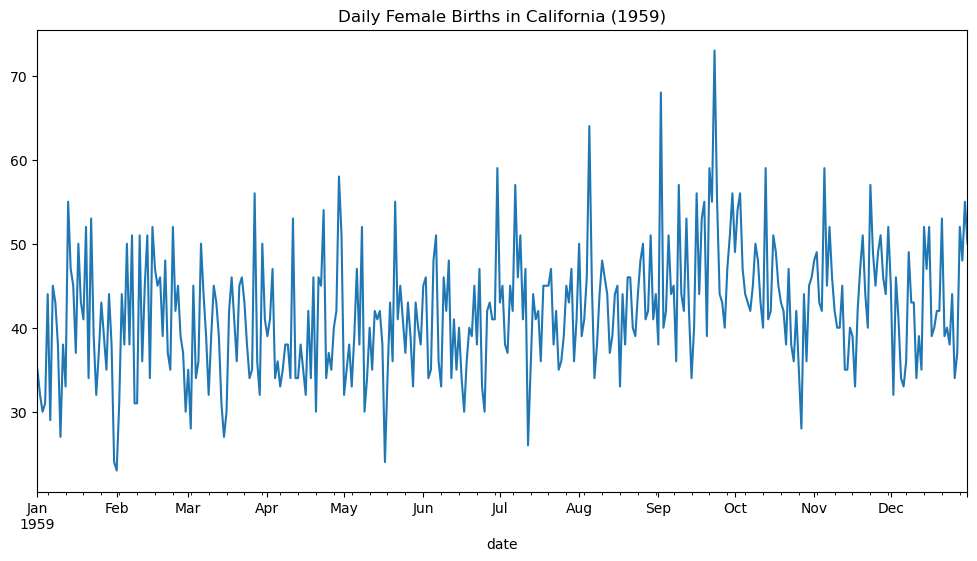

In [7]:
###visualizing data to gain insights
df['births'].plot(figsize=(12, 6), title='Daily Female Births in California (1959)')
plt.show()

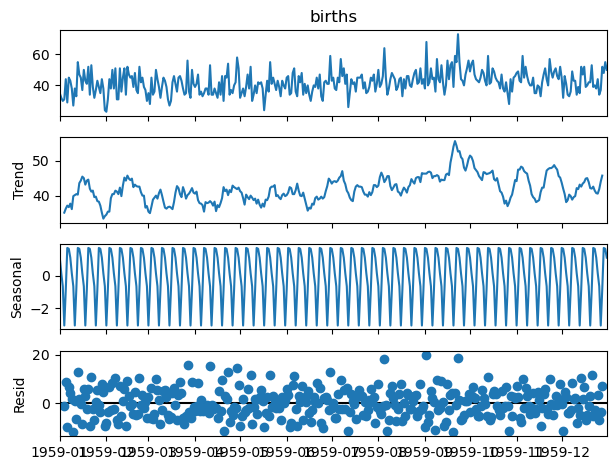

In [8]:
#VISUALIZING SEASONAL DECOMPOSE
decomposition = seasonal_decompose(df['births'], model='additive')
decomposition.plot()
plt.show()

In [9]:
#### SPLITTING TRAIN AND TEST DATA
train = df[:'1959-10']
test = df['1959-11':]

print(train.shape, test.shape)

(304, 1) (61, 1)


In [10]:
##### AUTO-ARIMA MODEL
model = auto_arima(train['births'], d = 1, D = 1, seasonal = True, m = 12, max_order = 6,
                     start_p = 0, start_q = 0, test = 'adf', trace = True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2348.606, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2185.916, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.33 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=2285.545, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=2151.814, Time=0.26 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.11 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.48 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=2214.615, Time=0.18 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=2135.607, Time=0.32 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=2175.270, Time=0.13 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=0.92 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.59 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=2120.884, Time=0.39 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=2159.2

In [11]:
arima_forecast = model.predict(n_periods=len(test))
arima_forecast = pd.Series(arima_forecast, index=test.index)


In [12]:
arima_mse = mean_squared_error(test['births'], arima_forecast)
arima_mape = mean_absolute_percentage_error(test['births'], arima_forecast)

print(f'Auto ARIMA MSE: {arima_mse}')
print(f'Auto ARIMA MAPE: {arima_mape:.2f}%')


Auto ARIMA MSE: 117.83487941672598
Auto ARIMA MAPE: 0.19%


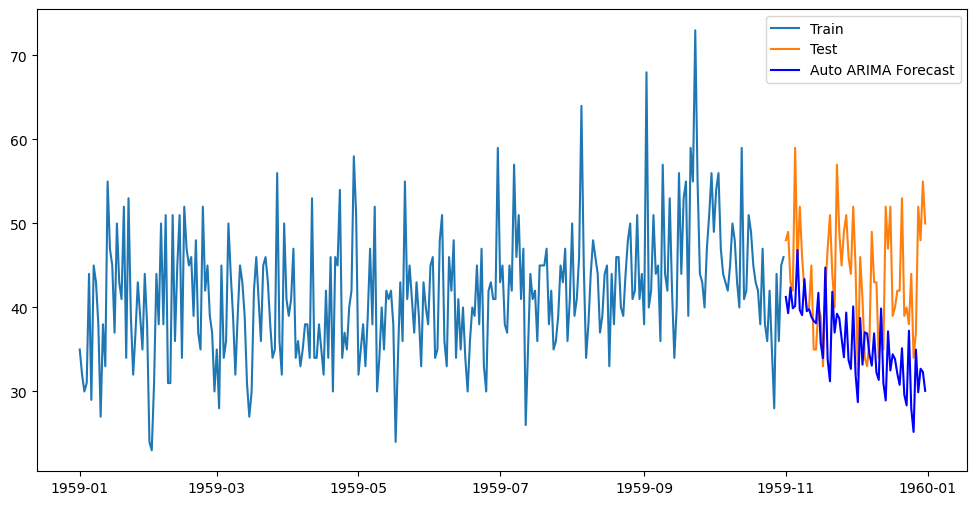

In [13]:
#visualizing Auto aRIMA MODEL
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['births'], label='Train')
plt.plot(test.index, test['births'], label='Test')
plt.plot(test.index, arima_forecast, label='Auto ARIMA Forecast', color='blue')
plt.legend()
plt.show()


ETS MSE: 48.17605482734389
ETS MAPE: 0.14%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


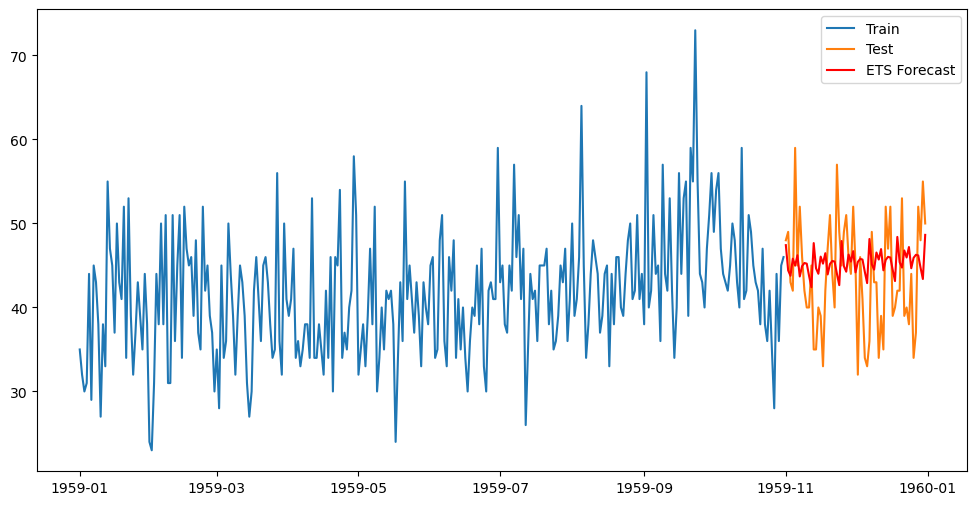

In [14]:
####EXPONENTIAL SMOOTHING MODEL

from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit Exponential Smoothing model
ets_model = ExponentialSmoothing(train['births'], trend='add', seasonal='add', seasonal_periods=12)
ets_fit = ets_model.fit()

# Forecast
ets_forecast = ets_fit.forecast(steps=len(test))
ets_forecast = pd.Series(ets_forecast, index=test.index)

# Evaluate ETS model
ets_mse = mean_squared_error(test['births'], ets_forecast)
ets_mape = mean_absolute_percentage_error(test['births'], ets_forecast)

print(f'ETS MSE: {ets_mse}')
print(f'ETS MAPE: {ets_mape:.2f}%')

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['births'], label='Train')
plt.plot(test.index, test['births'], label='Test')
plt.plot(test.index, ets_forecast, label='ETS Forecast', color='red')
plt.legend()
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


SARIMA MSE: 46.72126653883511
SARIMA MAPE: 0.14%


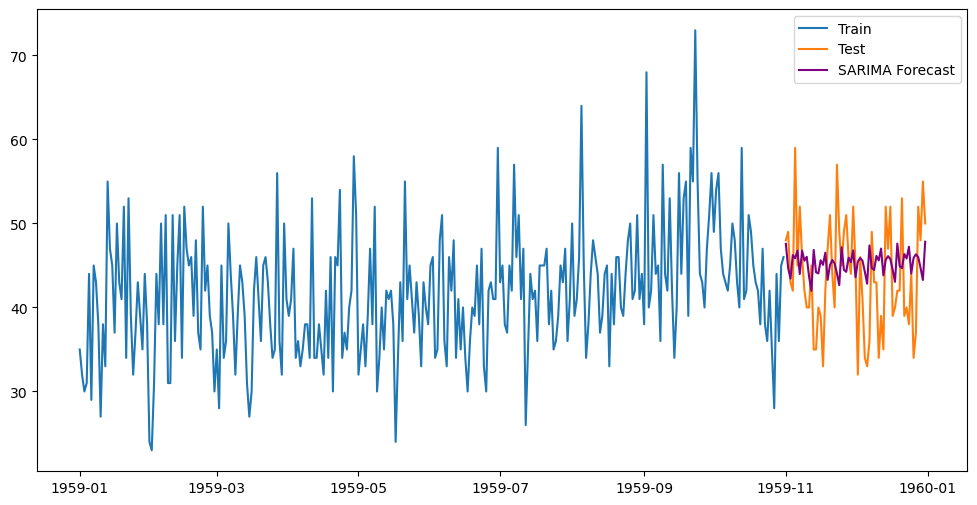

In [15]:
###SARIMAX model 
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA model
sarima_model = SARIMAX(train['births'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit(disp=False)

# Forecast
sarima_forecast = sarima_fit.forecast(steps=len(test))
sarima_forecast = pd.Series(sarima_forecast, index=test.index)

# Evaluate SARIMA model
sarima_mse = mean_squared_error(test['births'], sarima_forecast)
sarima_mape = mean_absolute_percentage_error(test['births'], sarima_forecast)

print(f'SARIMA MSE: {sarima_mse}')
print(f'SARIMA MAPE: {sarima_mape:.2f}%')

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['births'], label='Train')
plt.plot(test.index, test['births'], label='Test')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='purple')
plt.legend()
plt.show()


Auto ARIMA MSE: 117.83487941672598 || MAPE: 0.19%
ETS MSE: 48.17605482734389 || MAPE: 0.14%
SARIMA MSE: 46.72126653883511 || MAPE: 0.14%


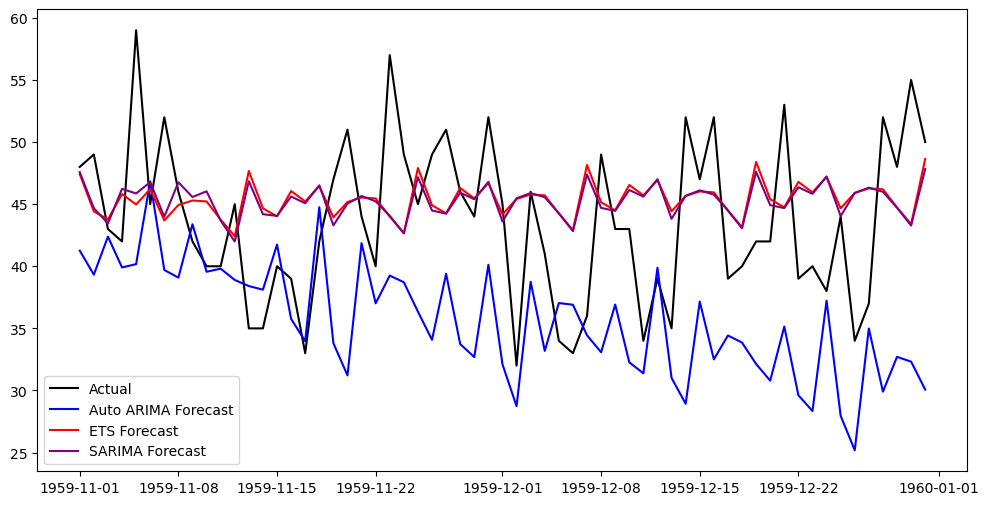

In [16]:
####Comparing the three models , choosing the one with the lowest MSE
print(f'Auto ARIMA MSE: {arima_mse} || MAPE: {arima_mape:.2f}%')
print(f'ETS MSE: {ets_mse} || MAPE: {ets_mape:.2f}%')
print(f'SARIMA MSE: {sarima_mse} || MAPE: {sarima_mape:.2f}%')


# Combined Plot for all models
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['births'], label='Actual', color='black')
plt.plot(test.index, arima_forecast, label='Auto ARIMA Forecast', color='blue')
plt.plot(test.index, ets_forecast, label='ETS Forecast', color='red')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='purple')
plt.legend()
plt.show()

In [ ]:
#seems like Sarima is the best match for our forecast as it has the lowest MSE